# Step 3 - Points of interest based bicycle network generation
## Project: Growing Urban Bicycle Networks

This notebook follows the transit-oriented development approach of palominos2020ica or a grid approach and applies cardillo2006spp: Take the greedy triangulation between railway/underground stations (or other points of interest created in 02_prepare_pois). This is the cold start bicycle network generation process which creates bicycle networks from scratch.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-18  
Last modified: 2021-01-23

## Preliminaries

### Parameters

In [1]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [2]:
%run -i path.py
%run -i setup.py

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.



=== Cities ===
{   'newcastle': {   'countryid': 'gbr',
                     'name': 'Newcastle upon Tyne',
                     'nominatimstring': 'Newcastle upon Tyne'}}


Setup finished.

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.29.0

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 7b0b51555d254a4f8cb8f65191b06ac8bdf94bd1

csv       : 1.0
watermark : 2.5.0
rasterio  : 1.3.11
json      : 2.0.9
shapely   : 2.0.6
geopandas : 0.14.4
haversine : 2.8.1
IPython   : 8.29.0
numpy     : 1.26.4
osmnx     : 1.9.4
matplotlib: 3.8.4
momepy    : 0.8.1
networkx  : 3.3
owslib    : 0.32.0
pyproj    : 3.7.0
geojson   : 3.1.0
sys       : 3.12.6 | packaged by conda-forge | (main, Sep 22 2024, 14:01:26) [MSC v.1941 64 bit (AMD64)]
pandas    : 2.2.3
osgeo     : 3.9.3
tqdm      : 4.66.

### Functions

In [3]:
%run -i functions.py

Loaded functions.



## Routing (shortest paths)

The function and code below currently routes between the edges of neighbourhoods, rather than from a single point to a single point. We then join the neighbourhoods up first, before considering the wider area. This wider area is derived from hexagonal tesslleations within the city boundaries.

In [4]:
def csv_to_ox(p, placeid, parameterid):
    """ Load a networkx graph from _edges.csv and _nodes.csv
    The edge file must have attributes u,v,osmid,length
    The node file must have attributes y,x,osmid
    Only these attributes are loaded.
    """
    prefix = placeid + '_' + parameterid
    compress = check_extract_zip(p, prefix)
    
    with open(p + prefix + '_edges.csv', 'r') as f:
        header = f.readline().strip().split(",")

        lines = []
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = str(eval(line_list[header.index("osmid")])[0]) if isinstance(eval(line_list[header.index("osmid")]), list) else line_list[header.index("osmid")] # If this is a list due to multiedges, just load the first osmid
            length = str(eval(line_list[header.index("length")])[0]) if isinstance(eval(line_list[header.index("length")]), list) else line_list[header.index("length")] # If this is a list due to multiedges, just load the first osmid
            line_string = "" + line_list[header.index("u")] + " "+ line_list[header.index("v")] + " " + osmid + " " + length
            lines.append(line_string)
        G = nx.parse_edgelist(lines, nodetype = int, data = (("osmid", int),("length", float)), create_using = nx.MultiDiGraph) # MultiDiGraph is necessary for OSMNX, for example for get_undirected(G) in utils_graph.py
    with open(p + prefix + '_nodes.csv', 'r') as f:
        header = f.readline().strip().split(",")
        values_x = {}
        values_y = {}
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = int(line_list[header.index("osmid")])
            values_x[osmid] = float(line_list[header.index("x")])
            values_y[osmid] = float(line_list[header.index("y")])

        nx.set_node_attributes(G, values_x, "x")
        nx.set_node_attributes(G, values_y, "y")

    if compress:
        os.remove(p + prefix + '_nodes.csv')
        os.remove(p + prefix + '_edges.csv')
    return G


In [5]:
# get nodes 

locations = {}
parameterinfo = osmnxparameters['carall']
G_caralls = {}
G_caralls_simplified = {}

for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(f"Processing {placeid}")
    
    # Load Tesselation POIs (hard coded for now)
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '_nnidsbikeall.csv') as f:
        tessellation_nnids = [int(line.rstrip()) for line in f]


    # Load LTN POIs
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry']))  # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox_highway(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrackcarall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(f"{placeid}: Loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    

    # load tesselation points 
    tess_nodes = gpd.read_file(PATH["data"] + placeid + "/" + placeid + '_poi_tessellation.gpkg')

    exit_points = get_exit_nodes(neighbourhoods, G_carall)  # Requires osmnx G_carall, not igraph G_carall
        
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items():  # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighbourhood in the GeoDataFrame to reference throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighbourhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
    # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y))  # We now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns
    
    ltn_nodes = all_centroids

    # add nearest node ID from G_carall 
    tess_nn = get_nearest_nodes_to_gdf(G_carall, tess_nodes)
    ltn_nn = get_nearest_nodes_to_gdf(G_carall, ltn_nodes)
    tess_nodes['osmid'] = tess_nn
    ltn_nodes['osmid'] = ltn_nn

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

Processing newcastle
newcastle: Loading and moving POIs
1 Cities loaded


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:2059: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded_gdf = gdf.explode().reset_index(drop=True)
c:\Users\b8008458\AppData\Local\miniforge3\envs\growbikenet\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:1862: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration

Processing neighbourhoods in: Newcastle Upon Tyne
Assigned neighbourhood_ids from 0 to 9 for Newcastle Upon Tyne


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:1725: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid  # Calculate centroids for each polygon


In [6]:
# get graph
# reload graph to ensure we have highway type information
G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
G_weighted = copy.deepcopy(G_caralls[placeid])


tag_lts = {
    "motorway": 4,
    "motorway_link": 4,
    "trunk": 4,
    "trunk_link": 4,
    "primary": 4,
    "primary_link": 4,
    "secondary": 4,
    "secondary_link": 4,
    "tertiary": 3,
    "tertiary_link": 3,
    "unclassified": 3,
    "residential": 2,
    "living_street": 2,
    "cycleway": 1,
    "track": 1,
    "path": 1,
    "bridleway": 1
}

# Iterate over the edges and update the 'length' attribute
for u, v, key, data in G_weighted.edges(keys=True, data=True):
    highway = data.get('highway') 
    length = data.get('length')  
    lts = tag_lts.get(highway, 1)  # Get the LTS value, default to 1 if highway type not in tag_lts
    G_weighted[u][v][key]['length'] *= lts  # Multiply length by LTS value

# set the graph to route on to undirected 
G_weighted = G_weighted.to_undirected()

In [7]:
# Produce triangulation for LTN nodes
greedy_triangulation_ltns_gdf = greedy_triangulation_ltns(ltn_nodes)
ltn_node_pairs = get_ltn_node_pairs(ltn_nodes, greedy_triangulation_ltns_gdf)

In [8]:
# Build the greedy triangulation graph using both sets of seed points
greedy_gdf, ltn_gdf, tess_gdf = build_greedy_triangulation(ltn_nodes, tess_nodes)
max_length = greedy_gdf['distance'].sum() # find the size of the fully connected graph


In [9]:
import networkx as nx
import momepy

# Create the NetworkX graph and add edges
greedy_triangulation_all_gdf = greedy_gdf
GT_abstract = nx.Graph()

# Add edges to the graph
for _, row in greedy_triangulation_all_gdf.iterrows():
    start = row['start_osmid']
    end = row['end_osmid']
    distance = row['distance']
    GT_abstract.add_edge(start, end, geometry=row['geometry'], distance=distance)

# Add node attributes from the combined GeoDataFrame
combined_gdf = pd.concat([ltn_nodes, tess_nodes], ignore_index=True)
attributes = combined_gdf.set_index('id').to_dict('index')
nx.set_node_attributes(GT_abstract, attributes)

# Calculate edge betweenness centrality (ebc)
ebc = nx.edge_betweenness_centrality(GT_abstract, weight='distance', normalized=True)
# Add the ebc as an edge attribute
for (u, v), value in ebc.items():
    GT_abstract[u][v]['ebc'] = value

# Now, convert the graph to a GeoDataFrame using momepy
# The graph is assumed to have 'geometry' in its edge attributes

edges_gdf = momepy.nx_to_gdf(GT_abstract, points=False, lines=True)

# Print the resulting GeoDataFrame (you can inspect it as well)
edges_gdf.set_crs(epsg=3857, inplace=True)

edges_gdf.explore(column='ebc', cmap='viridis', legend=True)

C:\Users\b8008458\AppData\Local\Temp\ipykernel_12480\2770871893.py:29: UserWarning: Approach is not set. Defaulting to 'primal'.
  edges_gdf = momepy.nx_to_gdf(GT_abstract, points=False, lines=True)


In [10]:
# get ebc and order edges for the greedy triangulation
greedy_triangulation_all_gdf, ltn_points_gdf, tess_points_gdf = greedy_triangulation_all(ltn_nodes, tess_nodes)
ebc_ltn, ebc_other, shortest_paths_ltn, shortest_paths_other = get_ebc_of_shortest_paths(greedy_triangulation_all_gdf, ltn_points_gdf, tess_points_gdf, ltn_node_pairs)

if debug:
    print(ebc_ltn)
    print(ebc_other)

{(59746799, 828943634): 0, (30124047, 112111611): 0, (30124047, 827268070): 0, (252735590, 778167846): 0.0016415868673050615, (252735590, 8785678172): 0.0027359781121751026, (59746799, 252735590): 0.004103967168262654, (8785678172, 10290135285): 0.006019151846785226, (252735590, 828943634): 0.009302325581395349, (30124047, 778167846): 0.01121751025991792, (4729421607, 10290135285): 0.015868673050615595, (30124047, 252735590): 0.0213406292749658, (828943634, 4729421607): 0.023255813953488372, (828943634, 10290135285): 0.029822161422708618, (30124047, 59746799): 0.029822161422708618, (112111611, 4729421607): 0.03283173734610123, (827268070, 828943634): 0.04295485636114911, (828943634, 8785678172): 0.04514363885088919, (59746799, 827268070): 0.047332421340629274, (112111611, 827268070): 0.07359781121751026, (827268070, 4729421607): 0.08235294117647059, (112111611, 778167846): 0.08481532147742818}
{(865262083, 860957339): 0, (776926218, 321750801): 0, (964971021, 2380300320): 0, (964971021

In [ ]:
def adjust_triangulation_to_budget(triangulation_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges=None, ltn_node_pairs=None):
    """
    Adjust a given triangulation to fit within the specified budget D,
    ensuring that previously selected edges are always included.
    Only after all ltns are connected do we move to include the growth of other areas.
    """
    # make a graph
    G = nx.Graph()
    for _, row in triangulation_gdf.iterrows():
        G.add_edge(
            row['start_osmid'],
            row['end_osmid'],
            geometry=row['geometry'],
            distance=row['distance']
        )

    # Calculate edge betweenness centrality
    bc = nx.edge_betweenness_centrality(G, weight='distance', normalized=True)
    for (u, v), centrality in bc.items():
        G[u][v]['ebc'] = centrality

    total_length = 0
    selected_edges = set(previous_selected_edges or [])

    # Include previously selected edges so that we aren't starting from stratch each loop through
    for u, v in selected_edges:
        if G.has_edge(u, v):
            total_length += G[u][v]['distance']

    # Track the ltns which are connected
    connected_ltn_pairs = set()

    # Track all other connected pairs
    connected_other_pairs = set()

    # Prune for ltn node pairs first
    for (node1, node2), centrality in ebc_ltn.items():
        if node1 in G.nodes and node2 in G.nodes:
            edges = shortest_paths_ltn.get((node1, node2), [])
            if edges:  # If a valid path exists
                path_length = sum(G[u][v]['distance'] for u, v in edges)
                # Check if adding this path exceeds the budget D
                if total_length + path_length > D:
                    continue
                # Add the edges to selected_edges
                for u, v in edges:
                    selected_edges.add((u, v))
                total_length += path_length
                connected_ltn_pairs.add((node1, node2))  # Mark the pair as connected

    
    # Check if all ltn node pairs are connected
    if set(ltn_node_pairs).issubset(connected_ltn_pairs):
        # Now move to all other connections (ltn to tess, tess to tess, tess to ltn etc)
        for (node1, node2), centrality in ebc_other.items():
            if node1 in G.nodes and node2 in G.nodes:
                edges = shortest_paths_other.get((node1, node2), [])
                if edges:  # If a valid path exists
                    path_length = sum(G[u][v]['distance'] for u, v in edges)
                    # Check if adding this path exceeds the budget D
                    if total_length + path_length > D:
                        continue
                    # Add the edges to selected_edges
                    for u, v in edges:
                        selected_edges.add((u, v))
                    total_length += path_length
                    connected_other_pairs.add((node1, node2))
    # missing_pairs = [pair for pair in ltn_node_pairs if pair not in connected_ltn_pairs]

    # Build the adjusted GeoDataFrame
    lines = []
    distances = []
    start_osmids = []
    end_osmids = []
    betweeness = []

    for u, v in selected_edges:
        lines.append(G[u][v]['geometry'])
        distances.append(G[u][v]['distance'])
        start_osmids.append(u)
        end_osmids.append(v)
        betweeness.append(G[u][v]['ebc'])

    adjusted_gdf = gpd.GeoDataFrame({
        'geometry': lines,
        'start_osmid': start_osmids,
        'end_osmid': end_osmids,
        'distance': distances,
        'betweeness': betweeness,
    }, crs=triangulation_gdf.crs)

    return adjusted_gdf, selected_edges, connected_ltn_pairs, connected_other_pairs

Pruning GT abstract and routing on network for meters of investment:   0%|          | 0/23 [00:00<?, ?it/s]

Routing on network for investment level: 30000.0 with routdenodepairs [(30124047, 827268070), (30124047, 778167846), (59746799, 252735590), (59746799, 828943634), (30124047, 112111611), (252735590, 8785678172)]


Coniditional routing:   0%|          | 0/6 [00:00<?, ?it/s]

Routing on network for investment level: 55000.0 with routdenodepairs [(30124047, 827268070), (59746799, 252735590), (59746799, 828943634), (30124047, 112111611), (252735590, 8785678172)]


Coniditional routing:   0%|          | 0/5 [00:00<?, ?it/s]

Routing on network for investment level: 80000.0 with routdenodepairs [(30124047, 827268070), (59746799, 252735590), (59746799, 828943634), (828943634, 4729421607), (252735590, 778167846), (30124047, 112111611), (252735590, 8785678172)]


Coniditional routing:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

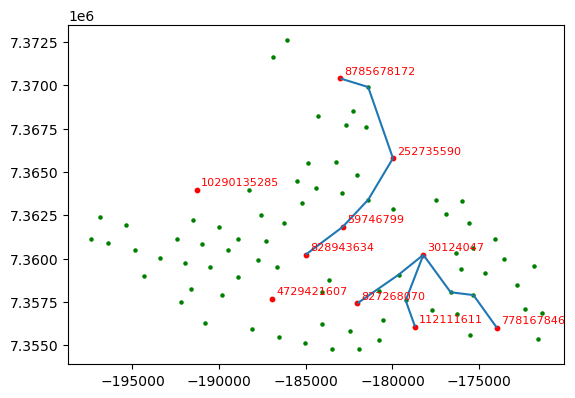

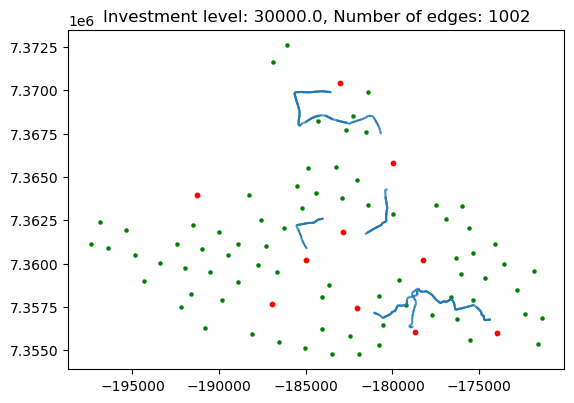

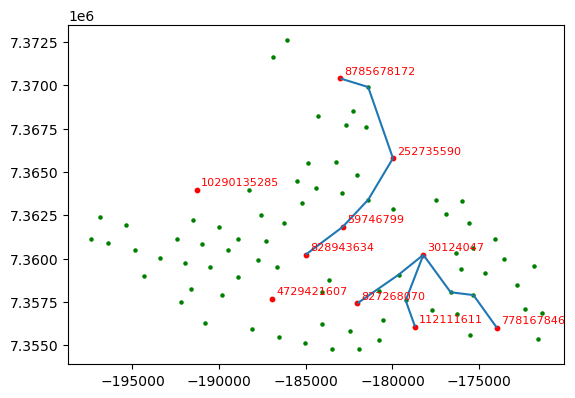

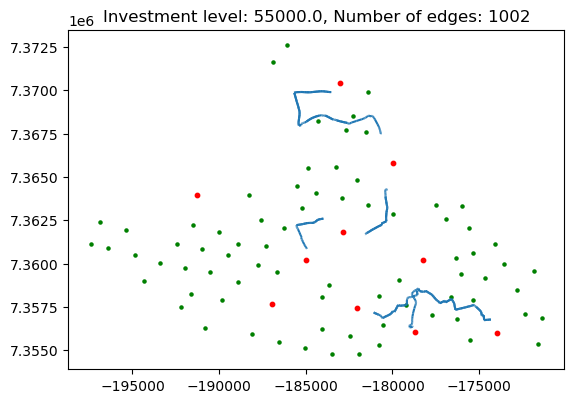

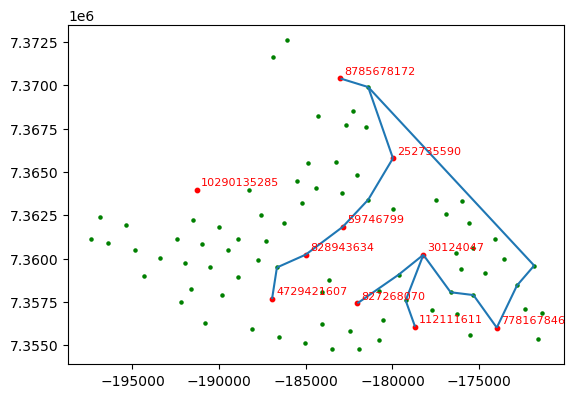

In [153]:
## many combinations

investment_levels = list(np.arange(30000, max_length, 25000)) # change to something more reasonable!!
previous_selected_edges = set()

GT_abstracts = []
GTs = []

global_processed_pairs = set()
cumulative_GT_indices = set()


for D in tqdm(investment_levels, desc="Pruning GT abstract and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    GT_abstract_gdf, previous_selected_edges, connected_ltn_pairs, connected_other_pairs = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    GT_abstracts.append(GT_abstract_nx)

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  # Use index or another column for labeling
                xy=(row.geometry.x, row.geometry.y),  # Get the coordinates of the point
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red"
        )
        
    poipairs = connected_ltn_pairs | connected_other_pairs
    routenodepairs = [(u, v) for u, v in poipairs]

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    GT_indices = set()
    
    ## conditional routing 
    # ltn --> ltn (all)
    # ltn --> tess (all to one)
    # tess --> tess (one to one)
    # tess --> ltn (one to all)

    GT_indices = set()
    processed_pairs = set()

    for u, v in tqdm(routenodepairs, desc='Coniditional routing'):
        poipair = (u, v)
        if poipair in global_processed_pairs or tuple(reversed(poipair)) in global_processed_pairs:
            continue
        
        # Determine if nodes are neighbourhood or tessellation
        is_u_neighbourhood = u in all_centroids['nearest_node'].values
        is_v_neighbourhood = v in all_centroids['nearest_node'].values
        
        if is_u_neighbourhood and is_v_neighbourhood:
            # Both nodes are neighbourhoods
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            
            exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
            exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs:
                        continue
                    processed_pairs.add(pair_id)
                    
                    try:
                        sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                        sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                        if sp_length < shortest_path_length:
                            shortest_path_length, best_path = sp_length, sp
                    except nx.NetworkXNoPath:
                        continue
            
            if best_path:
                GT_indices.update(best_path)

        elif is_u_neighbourhood and not is_v_neighbourhood:
            # Neighbourhood to Tessellation
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_id].index

            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and is_v_neighbourhood:
            # Tessellation to Neighbourhood
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_id].index

            shortest_path_length, best_path = float('inf'), None
            for eb in exit_points_b:
                try:
                    sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and not is_v_neighbourhood:
            # Tessellation to Tessellation
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
                GT_indices.update(sp)
            except nx.NetworkXNoPath:
                continue

        else:
            print("This should never happen.")

        global_processed_pairs.add(poipair) # track pairs that we've already routed between
    
    cumulative_GT_indices.update(GT_indices) # add routes we've already calculated previously to current GT

    # Generate subgraph for selected routes
    GT = G_caralls[placeid].subgraph(cumulative_GT_indices)
    deweight_edges(GT, tag_lts)
    GTs.append(GT)
        
    

    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")
        

        





C:\Users\b8008458\AppData\Local\Temp\ipykernel_12480\1571044016.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper left")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


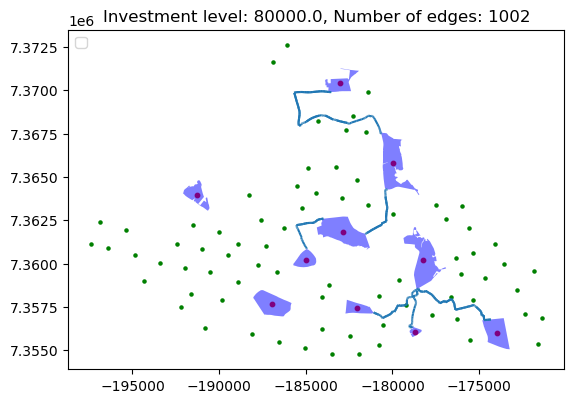

In [158]:
GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
GT_edges = GT_edges.to_crs(epsg=3857)
ax = GT_edges.plot()
ltn_gdf.plot(ax=ax, color='red', markersize=10)
tess_gdf.plot(ax=ax, color='green', markersize=5)


placename = "Newcastle Upon Tyne"  # Replace with the key of the neighbourhood you want to plot
if placename in neighbourhoods:
    neighbourhood_gdf = neighbourhoods[placename]
    neighbourhood_gdf = neighbourhood_gdf.to_crs(epsg=3857)  # Ensure the CRS matches
    neighbourhood_gdf.plot(ax=ax, color='blue', alpha=0.5, label=f"Neighbourhood: {placename}")

# Enhance plot aesthetics
ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")
ax.legend(loc="upper left")

In [ ]:
breakpoint()

# this is the end of the useful code. all other parts are for testing only 

In [ ]:
##################
# this is the old pruning code, which is much faster as it doesnt try to go to neighbourhood edges
##################

investment_levels = list(np.arange(30000, max_length, 25000)) # change to something more reasonable!!
previous_selected_edges = set()

GT_abstracts = []
GTs = []

for D in tqdm(investment_levels, desc="Pruning GT abstract and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    GT_abstract_gdf, previous_selected_edges, connected_ltn_pairs, connected_other_pairs = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    GT_abstracts.append(GT_abstract_nx)

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  
                xy=(row.geometry.x, row.geometry.y),  
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red")
        
    poipairs = connected_ltn_pairs | connected_other_pairs
    routenodepairs = [(u, v) for u, v in poipairs]

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    GT_indices = set()

    # do the on network routing
    for u, v in routenodepairs:
        sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
        GT_indices.update(sp)

    GT = G_caralls[placeid].subgraph(GT_indices)
    deweight_edges(GT, tag_lts)
    GTs.append(GT)
    
    
    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")

        

In [ ]:
breakpoint()

# and this is mostly useless but I don't want to get rid just yet. 

In [ ]:
## conditional routing 
# ltn --> ltn (all)
# ltn --> tess (all to one)
# tess --> tess (one to one)
# tess --> ltn (one to all)

GT_indices = set()
processed_pairs = set()

for poipair, poipair_distance in tqdm(routenodepairs):
    u, v = poipair
    
    # Determine if nodes are neighbourhood or tessellation
    is_u_neighbourhood = u in all_centroids['nearest_node'].values
    is_v_neighbourhood = v in all_centroids['nearest_node'].values
    
    if is_u_neighbourhood and is_v_neighbourhood:
        # Both nodes are neighbourhoods
        neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
        neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
        
        exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
        exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index
        
        shortest_path_length, best_path = float('inf'), None
        for ea in exit_points_a:
            for eb in exit_points_b:
                pair_id = tuple(sorted((ea, eb)))
                if pair_id in processed_pairs:
                    continue
                processed_pairs.add(pair_id)
                
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
        
        if best_path:
            GT_indices.update(best_path)

    elif is_u_neighbourhood and not is_v_neighbourhood:
        # Neighbourhood to Tessellation
        neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
        exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_id].index

        shortest_path_length, best_path = float('inf'), None
        for ea in exit_points_a:
            try:
                sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                if sp_length < shortest_path_length:
                    shortest_path_length, best_path = sp_length, sp
            except nx.NetworkXNoPath:
                continue
        
        if best_path:
            GT_indices.update(best_path)

    elif not is_u_neighbourhood and is_v_neighbourhood:
        # Tessellation to Neighbourhood
        neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
        exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_id].index

        shortest_path_length, best_path = float('inf'), None
        for eb in exit_points_b:
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                if sp_length < shortest_path_length:
                    shortest_path_length, best_path = sp_length, sp
            except nx.NetworkXNoPath:
                continue
        
        if best_path:
            GT_indices.update(best_path)

    elif not is_u_neighbourhood and not is_v_neighbourhood:
        # Tessellation to Tessellation
        try:
            sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
            GT_indices.update(sp)
        except nx.NetworkXNoPath:
            continue

    else:
        print("This should never happen.")

# Generate subgraph for selected routes
GT = G_caralls[placeid].subgraph(GT_indices)
deweight_edges(GT, tag_lts)
GTs.append(GT)


In [ ]:
# run for one set of routenodepairs (rather than many kms of them)
GT_indices = set()
processed_pairs = set()

for poipair, poipair_distance in tqdm(routenodepairs):
    u, v = poipair
    
    # Determine if nodes are neighbourhood or tessellation
    is_u_neighbourhood = u in all_centroids['nearest_node'].values
    is_v_neighbourhood = v in all_centroids['nearest_node'].values
    
    if is_u_neighbourhood and is_v_neighbourhood:
        print("Both neighbourhoods")
        # Both nodes are neighbourhoods
        neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
        neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
        
        exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
        exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index
        
        shortest_path_length, best_path = float('inf'), None
        for ea in exit_points_a:
            for eb in exit_points_b:
                pair_id = tuple(sorted((ea, eb)))
                if pair_id in processed_pairs:
                    continue
                processed_pairs.add(pair_id)
                
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
        
        if best_path:
            GT_indices.update(best_path)

    elif is_u_neighbourhood and not is_v_neighbourhood:
        print("Neighbourhood to Tessellation")
        # Neighbourhood to Tessellation
        neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
        exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_id].index

        shortest_path_length, best_path = float('inf'), None
        for ea in exit_points_a:
            try:
                sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                if sp_length < shortest_path_length:
                    shortest_path_length, best_path = sp_length, sp
            except nx.NetworkXNoPath:
                continue
        
        if best_path:
            GT_indices.update(best_path)

    elif not is_u_neighbourhood and is_v_neighbourhood:
        print("Tessellation to Neighbourhood")
        # Tessellation to Neighbourhood
        neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
        exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_id].index

        shortest_path_length, best_path = float('inf'), None
        for eb in exit_points_b:
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                if sp_length < shortest_path_length:
                    shortest_path_length, best_path = sp_length, sp
            except nx.NetworkXNoPath:
                continue
        
        if best_path:
            GT_indices.update(best_path)

    else:
        # Tessellation to Tessellation
        try:
            sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
            GT_indices.update(sp)
        except nx.NetworkXNoPath:
            continue

# Generate subgraph for selected routes
GT = G_caralls[placeid].subgraph(GT_indices)
deweight_edges(GT, tag_lts)
GTs.append(GT)


In [ ]:
test = neighbourhoods['Newcastle Upon Tyne'].to_crs(epsg=3857)

In [ ]:
if debug:
    GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
    GT_edges = GT_edges.to_crs(epsg=3857)
    ax = GT_edges.plot()
    ltn_gdf.plot(ax=ax, color='red', markersize=10)
    tess_gdf.plot(ax=ax, color='green', markersize=5)
    test.plot(ax=ax, color='blue', alpha=0.5)

In [ ]:
# G_caralls[placeid] = csv_to_ox_highway(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
# G_caralls[placeid].graph["crs"] = 'epsg:3857'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

In [ ]:
GT_abstract_gdf.explore()

In [ ]:
greedy_gdf.plot()

In [ ]:
## debuging folium map

import folium
# Reproject the GeoDataFrames to EPSG:4326 (WGS 84)
GT_abstract_gdf_plot = GT_abstract_gdf.to_crs(epsg=4326)
ltn_gdf_plot = ltn_gdf.to_crs(epsg=4326)
tess_gdf_plot = tess_gdf.to_crs(epsg=4326)
GT_edges_plot = GT_edges.to_crs(epsg=4326) 
m = folium.Map(location=[GT_abstract_gdf_plot.geometry.centroid.y.mean(), GT_abstract_gdf_plot.geometry.centroid.x.mean()], zoom_start=12)
folium.GeoJson(
    GT_abstract_gdf_plot.to_json(), 
    name="GT_abstract_edges",
    style_function=lambda x: {'color': 'blue', 'weight': 3, 'opacity': 0.7}  # Thicker and blue edges
).add_to(m)
folium.GeoJson(
    GT_edges_plot.to_json(), 
    name="GT_edges",
    style_function=lambda x: {'color': 'red', 'weight': 3, 'opacity': 0.7}  # Red lines for GT_edges
).add_to(m)

for _, row in ltn_gdf_plot.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x], 
        popup=f"OSMID: {row['osmid']}",
        icon=folium.Icon(color='red')
    ).add_to(m)
for _, row in tess_gdf_plot.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x], 
        radius=4,  # Smaller radius for tess_gdf points
        color='green',  # Green color
        fill=True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(m)


m


In [ ]:





# Do the routing between the LTN nodes
if weighting:
    routed_nodes = set()
    for (node1, node2), _ in ebc_ltn.items():
        sp = nx.shortest_path(G_weighted, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_weighted.subgraph(routed_nodes).copy()

else:
    routed_nodes = set()
    for (node1, node2), _ in ebc_ltn.items():
        sp = nx.shortest_path(G_carall, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_carall.subgraph(routed_nodes).copy()


if debug:
    route_nodes, route_edges = ox.graph_to_gdfs(routed_subgraph)
    ax = route_edges.plot()
    ltn_nodes.plot(ax=ax, color='red')
    tess_nodes.plot(ax=ax, color='green')


# Do the routing between the other nodes
if weighting:
    routed_nodes = set()
    for (node1, node2), _ in ebc_other.items():
        sp = nx.shortest_path(G_weighted, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_weighted.subgraph(routed_nodes).copy()

else:
    routed_nodes = set()
    for (node1, node2), _ in ebc_other.items():
        sp = nx.shortest_path(G_carall, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_carall.subgraph(routed_nodes).copy()


if debug:
    route_nodes, route_edges = ox.graph_to_gdfs(routed_subgraph)
    ax = route_edges.plot()
    ltn_nodes.plot(ax=ax, color='red')
    tess_nodes.plot(ax=ax, color='green')


In [ ]:


# Do the routing between the LTN nodes
if weighting:
    routed_nodes = set()
    for (node1, node2), _ in ebc_ltn.items():
        sp = nx.shortest_path(G_weighted, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_weighted.subgraph(routed_nodes).copy()

else:
    routed_nodes = set()
    for (node1, node2), _ in ebc_ltn.items():
        sp = nx.shortest_path(G_carall, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_carall.subgraph(routed_nodes).copy()


if debug:
    route_nodes, route_edges = ox.graph_to_gdfs(routed_subgraph)
    ax = route_edges.plot()
    ltn_nodes.plot(ax=ax, color='red')
    tess_nodes.plot(ax=ax, color='green')



In [ ]:
# Do the routing between the other nodes
if weighting:
    routed_nodes = set()
    for (node1, node2), _ in ebc_other.items():
        sp = nx.shortest_path(G_weighted, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_weighted.subgraph(routed_nodes).copy()

else:
    routed_nodes = set()
    for (node1, node2), _ in ebc_other.items():
        sp = nx.shortest_path(G_carall, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_carall.subgraph(routed_nodes).copy()


if debug:
    route_nodes, route_edges = ox.graph_to_gdfs(routed_subgraph)
    ax = route_edges.plot()
    ltn_nodes.plot(ax=ax, color='red')
    tess_nodes.plot(ax=ax, color='green')


In [ ]:
investment_levels = list(np.arange(5000,95000,5000))



In [ ]:
# TO DO
make it work in loop -  X DONE 
neighbourhood exit points -- DONE BUT SLOW 


rustworkx for speeding up routing

do proper weighting - will need more tags in the cvs file

run a comparison of weighted, weightined with cycle = 0 and unweighted routing. results seem dramatic atm

Plot ebc on graph to show that edges are kinda weird

join up to useful part of neighbourhoods?

Snap to stroke when no network to snap to 

snap to largest cycle component in cell rather than just nearest? 

Get into format that can be used in later analysis 




In [ ]:
import rustworkx as rx
test = rx.networkx_converter(G_weighted, keep_attributes=True)
sp = rx.dijkstra_shortest_paths(test, source=u, target=v, weight_fn='length')

In [ ]:
nx.get_edge_attributes(routed_subgraph, 'geometry')

In [ ]:
ltn_node_ids = set(ltn_nodes['id'])
ebc_filtered = [(edge, centrality) for edge, centrality in ebc.items() if edge[0] in ltn_node_ids and edge[1] in ltn_node_ids]
ebc_filtered

In [ ]:
G.nodes(data=True)

In [ ]:
G.edges(data=True)

In [ ]:
set([1,2,3,4,5,5])

In [ ]:
ltn_node_pairs

In [ ]:
greedy_triangulation_all_gdf.explore()

In [ ]:
G.edges(data=True)

In [ ]:
G.nodes(data=True)

In [ ]:
break

In [ ]:
# # bog standard pruning
# for D in investment_levels:
#     GT_abstract = adjust_triangulation_to_budget(
#         greedy_gdf, D)
#     ax = GT_abstract.plot()
#     ltn_gdf.plot(ax=ax, color='red', markersize=10)
#     tess_gdf.plot(ax=ax, color='green', markersize=10)

In [ ]:
# # bog standard pruning
# def adjust_triangulation_to_budget(triangulation_gdf, D):
#     """
#     Adjust a given triangulation to fit within the specified budget D.
#     """
#     G = nx.Graph()
#     for _, row in triangulation_gdf.iterrows():
#         G.add_edge(
#             row['start_osmid'],
#             row['end_osmid'],
#             geometry=row['geometry'],
#             distance=row['distance']
#         )

#     bc = nx.edge_betweenness_centrality(G, normalized=True)

#     for (u,v), centrality in bc.items():
#         G[u][v]['ebc'] = centrality
    
#     ebc =[(u,v,G[u][v]['distance'], G[u][v]['ebc'])
#             for u,v in G.edges()]
    
#     ebc.sort(key=lambda x: x[3], reverse=False)
#     total_length = 0
#     selected_edges=[]

#     for u,v,distance,centrality in ebc:
#         if total_length + distance > D:
#             break
#         selected_edges.append((u,v,distance,centrality))
#         total_length += distance
    
#     # Build the adjusted GeoDataFrame
#     lines = []
#     distances = []
#     start_osmids = []
#     end_osmids = []
#     betweeness = []
    
#     for u, v, distance, centrality in selected_edges:
#         lines.append(G[u][v]['geometry'])
#         distances.append(distance)
#         start_osmids.append(u)
#         end_osmids.append(v)
#         betweeness.append(centrality)

    
#     adjusted_gdf = gpd.GeoDataFrame({
#         'geometry': lines,
#         'start_osmid': start_osmids,
#         'end_osmid': end_osmids,
#         'distance': distances,
#         'betweeness': betweeness,
#     }, crs=triangulation_gdf.crs)
    
#     # Print total length for validation
#     # print(f"Total length of selected edges: {total_length:.2f} (Budget: {D})")
    
#     return adjusted_gdf


# # Build the greedy triangulation
# greedy_gdf, ltn_gdf, tess_gdf = build_greedy_triangulation(ltn_points_gdf, tess_points_gdf)

# # Adjust the triangulation to fit within the budget
# adjusted_gdf = adjust_triangulation_to_budget(greedy_gdf, D=20000)


In [ ]:
break

In [ ]:
## do the triangulation and routing

# Load data again to ensure we account for neighbourhoods correctly
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
locations = {}
parameterinfo = osmnxparameters['carall']





for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(f"{placeid}: Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry']))  # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(f"{placeid}: Loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    exit_points = get_exit_nodes(neighbourhoods, G_carall)  # Requires osmnx G_carall, not igraph G_carall
        
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items():  # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighbourhood in the GeoDataFrame to reference throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighbourhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
    # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y))  # We now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns

    # Load Tesselation POIs (hard coded for now)
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '_nnidsbikeall.csv') as f:
        tessellation_nnids = [int(line.rstrip()) for line in f]

    # Combine nnids
    nnids = neighbourhood_nnids | set(tessellation_nnids)

    # Load networks
    # G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall', weighting=weighting)  # To load car and cycle network

    # Generation
    (GTs, GT_abstracts) = greedy_triangulation_routing_mix(G_carall, neighbourhood_nnids, tessellation_nnids, weighting, prune_quantiles, prune_measure)
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)
    
    # Restore original edge lengths
    if weighting:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)

    # Write results
    results = {
        "placeid": placeid,
        "prune_measure": prune_measure,
        "poi_source": poi_source,
        "prune_quantiles": prune_quantiles,
        "GTs": GTs,
        "GT_abstracts": GT_abstracts,
        "MST": MST,
        "MST_abstract": MST_abstract
    }
    write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)


In [ ]:
break

In [ ]:
## how to covert graph to geodatafarme
nx.get_edge_attributes(G, 'geometry')

### Testing below

In [ ]:
def poipairs_by_distance_mix(G, pois, weighting=None, return_distances=False):
    """
    Calculates the (weighted) graph distances on G for a subset of nodes pois.
    Returns all pairs of POI ids sorted by:
    1. Source (neighbourhood-to-neighbourhood pairs first, then others).
    2. Distance (ascending order).
    If return_distances, then distances are also returned.
    """
    # Get poi indices
    indices = [G.vs.find(id=poi).index for poi in pois]

    # Map POI ids to their source type (neighbourhood or tessellation)
    poi_sources = {poi: 'neighbourhood' if poi in neighbourhood_nnids else 'tessellation' for poi in pois}

    # Get sequences of nodes and edges in shortest paths between all pairs of pois
    poi_nodes = []
    poi_edges = []
    for c, v in enumerate(indices):
        poi_nodes.append(G.get_shortest_paths(v, indices[c:], weights="weight", output="vpath"))
        poi_edges.append(G.get_shortest_paths(v, indices[c:], weights="weight", output="epath"))

    # Sum up weights (distances) of all paths
    poi_dist = {}
    for paths_n, paths_e in zip(poi_nodes, poi_edges):
        for path_n, path_e in zip(paths_n, paths_e):
            if weighting:
                path_dist = sum([G.es[e]['ori_length'] for e in path_e])  # Use 'ori_length' for distance
            else:
                path_dist = sum([G.es[e]['weight'] for e in path_e])  # Fallback to 'weight' if weighting is False

            if path_dist > 0:
                poi_dist[(path_n[0], path_n[-1])] = path_dist

    # Back to POI ids and add source information
    temp = [
        ((G.vs[p[0][0]]["id"], G.vs[p[0][1]]["id"]), p[1],
         poi_sources[G.vs[p[0][0]]["id"]], poi_sources[G.vs[p[0][1]]["id"]])
        for p in poi_dist.items()
    ]

    # Sort by source (neighbourhood-to-neighbourhood first, then others), then by distance
    temp_sorted = sorted(
        temp,
        key=lambda x: (
            0 if x[2] == 'neighbourhood' and x[3] == 'neighbourhood' else 1,  # Primary: neighbourhood-to-neighbourhood first
            x[1]  # Secondary: ascending distance
        )
    )

    # Remove source information before returning (optional)
    if return_distances:
        return [(p[0], p[1]) for p in temp_sorted]
    else:
        return [p[0] for p in temp_sorted]


In [ ]:
#### this try is to mix both into the same poi pairs


def greedy_triangulation_routing_mix(G, neighbourhood_nnids, tessellation_nnids, weighting=None, prune_quantiles=[1], prune_measure="betweenness"):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    # Combine neighbourhood_nnids and tessellation_nnids with origin labels
    pois = [(node_id, 'neighbourhood') for node_id in neighbourhood_nnids] + \
           [(node_id, 'tessellation') for node_id in tessellation_nnids]

    if len(pois) < 2: 
        return [], []  # We can't do anything with less than 2 POIs

    # Separate POIs by origin (neighbourhood and tessellation)
    neighbourhood_pois = [poi for poi in pois if poi[1] == 'neighbourhood']
    tessellation_pois = [poi for poi in pois if poi[1] == 'tessellation']

    # Extract only the node ids for use in GT creation
    neighbourhood_ids = [poi[0] for poi in neighbourhood_pois]
    tessellation_ids = [poi[0] for poi in tessellation_pois]

    # Combine all POI indices and create POI pairs for all POIs
    combined_ids = neighbourhood_ids + tessellation_ids
    pois_indices = [G.vs.find(id=poi).index for poi in combined_ids]
    G_temp = copy.deepcopy(G)
    for e in G_temp.es:  # Delete all edges
        G_temp.es.delete(e)

    # Use poipairs_by_distance for the combined set of points
    poipairs = poipairs_by_distance_mix(G, combined_ids, weighting, True)

    print(poipairs)


    if len(poipairs) == 0: 
        return [], []

    if prune_measure == "random":
        # Create a random order for edges
        GT = copy.deepcopy(G.subgraph(pois_indices))
        for poipair, poipair_distance in poipairs:
            poipair_ind = (GT.vs.find(id=poipair[0]).index, GT.vs.find(id=poipair[1]).index)
            if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
                GT.add_edge(poipair_ind[0], poipair_ind[1], weight=poipair_distance)
        random.seed(0)
        edgeorder = random.sample(range(GT.ecount()), k=GT.ecount())
    else:
        edgeorder = False

    GT_abstracts = []
    GTs = []
    all_shortest_paths = []
    processed_pairs = set()
    GT_indices = set()  # Accumulated nodes for the final GT

    # Greedy Triangulation for neighbourhood pois first
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation", leave=False):
        # GT creation for "neighbourhood" pois first
        GT_abstract = copy.deepcopy(G.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        GT_abstracts.append(GT_abstract)
        ############ Temporary code for debugging purposes ############
        if debug:
            temp = ig_to_geojson(GT_abstract)
            temp_geo = [shape(geometry) for geometry in temp["geometries"]]
            temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
            print("Neighbourhood pois plot")
            ax = temp_gdf.plot(color = "red", label=f"GT_abstract for prune_quantile {prune_quantile}")
            all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
            plt.title(f"GT_abstract for prune_quantile {prune_quantile}")
            plt.show()   
        ###############################################################     


    ############ Temporary code for debugging purposes ############
    if debug:
        temp = ig_to_geojson(GT_abstract)
        temp_geo = [shape(geometry) for geometry in temp["geometries"]]
        temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
        print("Neighbourhood pois plot")
        ax = temp_gdf.plot(color = "red")
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
        plt.title("GT_Abstract for neighbourhoods")
        plt.show()   
    ###############################################################     


    
    if debug:
        for edge in GT_abstracts[0].es:
            print(edge.attributes())


    # Routing and creating GT for each prune_quantile
    GT_indices = set()

    # set an interator to do processing per GT_abstract in GT_abstracts
    for prune_quantile in tqdm(prune_quantiles, desc="Routing", leave=False):
        # Update GT_abstract within each prune_quantile
        GT_abstract = copy.deepcopy(G_temp.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        GT_abstracts.append(GT_abstract)
        
        # get node pairs we need to route, sorted by distance
        routenodepairs = { (e.source_vertex["id"], e.target_vertex["id"]): e["weight"] for e in GT_abstract.es }
        routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])

        for poipair, poipair_distance in routenodepairs:
            poipair_ind = (G.vs.find(id=poipair[0]).index, G.vs.find(id=poipair[1]).index)
            
            if any(poi[0] == poipair[0] and poi[1] == 'neighbourhood' for poi in pois):
                # Neighbourhood routing logic
                neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == poipair[0], 'neighbourhood_id'].values[0]
                neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == poipair[1], 'neighbourhood_id'].values[0]
                exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
                exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index

                shortest_path_length, best_path = float('inf'), None
                for ea in exit_points_a:
                    for eb in exit_points_b:
                        pair_id = tuple(sorted((ea, eb)))
                        if pair_id in processed_pairs: 
                            continue
                        processed_pairs.add(pair_id)
                        ea_vertex_index = G.vs.find(id=ea).index
                        eb_vertex_index = G.vs.find(id=eb).index
                        sp = G.get_shortest_paths(ea_vertex_index, eb_vertex_index, weights="weight", output="vpath")[0]
                        if sp and len(sp) < shortest_path_length:
                            shortest_path_length, best_path = len(sp), sp

                if best_path:
                    all_shortest_paths.append((poipair[0], poipair[1], shortest_path_length, best_path))
                    GT_indices.update(best_path)
                    
                    # Plotting for neighbourhood routing
                    GT = G.induced_subgraph([G.vs[idx] for idx in best_path])
                    GTs.append(GT)
            else:
                # Routing for tessellation pois (more general case)
                sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights="weight", output="vpath")[0])
                GT_indices = GT_indices.union(sp)

            
        # Final step: Create the final GT from the indices we've accumulated
        GT = G.induced_subgraph(GT_indices)
        GTs.append(GT)

        # Plot the current GT
        GT_gjson = ig_to_geojson(GT)
        GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
        GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

        # Plotting the GTs after each loop
        fig, ax = plt.subplots(figsize=(10, 10))
        GT_gdf.plot(ax=ax, color="blue", linewidth=1.5, label=f"GT for prune_quantile {prune_quantile}")
        
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
        exit_points.plot(ax=ax, color="red", marker="x", markersize=30, label="All Exit Points")

        plt.legend()
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Greedy Triangulation (GT) for prune_quantile = {prune_quantile}")
        plt.show()

    return GTs, GT_abstracts


In [ ]:
### THIS FUNCTION WORKS FOR ONE OR THE OTHER AT AT TIME


def greedy_triangulation_routing_mix(G, neighbourhood_nnids, tessellation_nnids, weighting=None, prune_quantiles=[1], prune_measure="betweenness"):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    # Combine neighbourhood_nnids and tessellation_nnids with origin labels
    pois = [(node_id, 'neighbourhood') for node_id in neighbourhood_nnids] + \
           [(node_id, 'tessellation') for node_id in tessellation_nnids]

    if len(pois) < 2: 
        return [], []  # We can't do anything with less than 2 POIs

    # Separate pois by origin (neighbourhood and tessellation)
    neighbourhood_pois = [poi for poi in pois if poi[1] == 'neighbourhood']
    tessellation_pois = [poi for poi in pois if poi[1] == 'tessellation']

    # Extract only the node ids for use in GT creation
    neighbourhood_ids = [poi[0] for poi in neighbourhood_pois]
    tessellation_ids = [poi[0] for poi in tessellation_pois]

    # Create POI pairs and indices for neighbourhoods first
    pois_indices = [G.vs.find(id=poi[0]).index for poi in neighbourhood_pois]
    poipairs = poipairs_by_distance(G, neighbourhood_ids, weighting, True)

    if len(poipairs) == 0: 
        return [], []

    if prune_measure == "random":
        # Create a random order for edges
        GT = copy.deepcopy(G.subgraph(pois_indices))
        for poipair, poipair_distance in poipairs:
            poipair_ind = (GT.vs.find(id=poipair[0]).index, GT.vs.find(id=poipair[1]).index)
            if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
                GT.add_edge(poipair_ind[0], poipair_ind[1], weight=poipair_distance)
        random.seed(0)
        edgeorder = random.sample(range(GT.ecount()), k=GT.ecount())
    else:
        edgeorder = False

    GT_abstracts = []
    neighbourhood_GT_abstracts = []
    tessellation_GT_abstracts = []
    GTs = []
    all_shortest_paths = []
    processed_pairs = set()
    GT_indices = set()  # Accumulated nodes for the final GT

    # Greedy Triangulation for neighbourhood pois first
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation", leave=False):
        # GT creation for "neighbourhood" pois first
        GT_abstract = copy.deepcopy(G.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        neighbourhood_GT_abstracts.append(GT_abstract)
        ############ Temporary code for debugging purposes ############
        if debug:
            temp = ig_to_geojson(GT_abstract)
            temp_geo = [shape(geometry) for geometry in temp["geometries"]]
            temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
            print("Neighbourhood pois plot")
            ax = temp_gdf.plot(color = "red", label=f"GT_abstract for prune_quantile {prune_quantile}")
            all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
            plt.title(f"GT_abstract for prune_quantile {prune_quantile}")
            plt.show()   
        ###############################################################     


    ############ Temporary code for debugging purposes ############
    if debug:
        temp = ig_to_geojson(GT_abstract)
        temp_geo = [shape(geometry) for geometry in temp["geometries"]]
        temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
        print("Neighbourhood pois plot")
        ax = temp_gdf.plot(color = "red")
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
        plt.title("GT_Abstract for neighbourhoods")
        plt.show()   
    ###############################################################     


    # After processing all neighbourhood pois, now process tessellation pois
    pois_indices = [G.vs.find(id=poi[0]).index for poi in tessellation_pois]
    poipairs = poipairs_by_distance(G, tessellation_ids, weighting, True)

    # GT creation for "tessellation" pois
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation for tessellation", leave=False):
        # Perform greedy triangulation for tessellation pois
        GT_abstract = copy.deepcopy(G.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        tessellation_GT_abstracts.append(GT_abstract)



    ############ Temporary code for debugging purposes ############
    if debug:
        temp = ig_to_geojson(GT_abstract)
        temp_geo = [shape(geometry) for geometry in temp["geometries"]]
        temp_gdf2 = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
        ax = temp_gdf2.plot()
        temp_gdf.plot(ax=ax, color = "red")
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
        plt.title("Abstract for tesselation")
        plt.show()
    ###############################################################

    



    # note that this is two different abstract graphs mashed together, not one nice triangulated graph
    # this may need changing, I am using to test the routing section   
    GT_abstracts =  neighbourhood_GT_abstracts + tessellation_GT_abstracts 
    # to join two abstract graphs together, we ensure we can keep track of the source
    for i, GT_abstract in enumerate(GT_abstracts):
        # Determine the source type
        if GT_abstract in neighbourhood_GT_abstracts:
            source_value = "neighbourhoods"
        elif GT_abstract in tessellation_GT_abstracts:
            source_value = "tessellation"
        else:
            raise ValueError("Graph not found in either neighbourhood or tessellation lists!")

        # Update edges with the "source" attribute
        for edge in GT_abstract.es:
            edge["source"] = source_value
    
    if debug:
        for edge in GT_abstracts[0].es:
            print(edge.attributes())


    # Routing and creating GT for each prune_quantile
    GT_indices = set()

    # set an interator to do processing per GT_abstract in GT_abstracts
    GT_abstracts_iterator = iter(GT_abstracts)

    ##################################TEMPORARY CODE FOR DEBUGGING PURPOSES##################################
    def double_prune_quantiles(prune_quantiles):
        # Initialize an empty list to hold the new quantiles
        doubled_quantiles = []
        
        # Iterate through the original quantiles and insert a midpoint between consecutive values
        for i in range(len(prune_quantiles) - 1):
            doubled_quantiles.append(prune_quantiles[i])  # Append the current quantile
            # Calculate and append the midpoint between consecutive quantiles
            midpoint = (prune_quantiles[i] + prune_quantiles[i + 1]) / 2
            doubled_quantiles.append(midpoint)
        
        # Append the last element of the original list
        doubled_quantiles.append(prune_quantiles[-1])
        
        return doubled_quantiles
    ###########################################################################################################

    
    dubs = double_prune_quantiles(prune_quantiles)

    for prune_quantile in tqdm(dubs, desc="Routing", leave=False):
        GT_abstract = next(GT_abstracts_iterator)
        routenodepairs = { (e.source_vertex["id"], e.target_vertex["id"]): e["weight"] for e in GT_abstract.es }
        routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])

        for poipair, poipair_distance in routenodepairs:
            poipair_ind = (G.vs.find(id=poipair[0]).index, G.vs.find(id=poipair[1]).index)
            
            if any(poi[0] == poipair[0] and poi[1] == 'neighbourhood' for poi in pois):
                # Neighbourhood routing logic
                neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == poipair[0], 'neighbourhood_id'].values[0]
                neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == poipair[1], 'neighbourhood_id'].values[0]
                exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
                exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index

                shortest_path_length, best_path = float('inf'), None
                for ea in exit_points_a:
                    for eb in exit_points_b:
                        pair_id = tuple(sorted((ea, eb)))
                        if pair_id in processed_pairs: 
                            continue
                        processed_pairs.add(pair_id)
                        ea_vertex_index = G.vs.find(id=ea).index
                        eb_vertex_index = G.vs.find(id=eb).index
                        sp = G.get_shortest_paths(ea_vertex_index, eb_vertex_index, weights="weight", output="vpath")[0]
                        if sp and len(sp) < shortest_path_length:
                            shortest_path_length, best_path = len(sp), sp

                if best_path:
                    all_shortest_paths.append((poipair[0], poipair[1], shortest_path_length, best_path))
                    GT_indices.update(best_path)
                    
                    # Plotting for neighbourhood routing
                    GT = G.induced_subgraph([G.vs[idx] for idx in best_path])
                    GTs.append(GT)
            else:
                # Routing for tessellation pois (more general case)
                sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights="weight", output="vpath")[0])
                GT_indices = GT_indices.union(sp)

         
        # Final step: Create the final GT from the indices we've accumulated
        GT = G.induced_subgraph(GT_indices)
        GTs.append(GT)


        if debug:
            # Plot the current GT
            GT_gjson = ig_to_geojson(GT)
            GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
            GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

            # Plotting the GTs after each loop
            fig, ax = plt.subplots(figsize=(10, 10))
            GT_gdf.plot(ax=ax, color="blue", linewidth=1.5, label=f"GT for prune_quantile {prune_quantile}")
            
            all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
            exit_points.plot(ax=ax, color="red", marker="x", markersize=30, label="All Exit Points")

            plt.legend()
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            plt.title(f"Greedy Triangulation (GT) for prune_quantile = {prune_quantile}")
            plt.show()

    return GTs, GT_abstracts


In [ ]:
## we need to load data again to ensure we take in neighbourhoods correctly
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
locations = {}
parameterinfo = osmnxparameters['carall']

for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry'])) # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(placeid + ": loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    exit_points = get_exit_nodes(neighbourhoods, G_carall) # requires osmnx G_carall, not igraph G_carall
        
    
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items(): # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighborhood in the GeoDataFrame to referance throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug == True:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighborhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
        # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y)) # we now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns

    # generate connections
    print("Loaded neighbourhoods and exit points", placeid + ": Generating networks")

    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidsbikeall.csv') as f:
        tessellation_nnids = [int(line.rstrip()) for line in f]
    print("Loaded tesselation points")

    # combine nnids
    nnids = neighbourhood_nnids | set(tessellation_nnids)

    # Load networks
    #G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall', weighting=weighting) # to load car and cycle network

    # Generation
    (GTs, GT_abstracts) = greedy_triangulation_routing_mix(G_carall, neighbourhood_nnids, tessellation_nnids, weighting, prune_quantiles, prune_measure)
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)
    
    # Restore orignal edge lengths
    if weighting == True:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)


    # Write results
    results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": prune_quantiles, "GTs": GTs, "GT_abstracts": GT_abstracts, "MST": MST, "MST_abstract": MST_abstract}
    write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

In [ ]:
debug = True

In [ ]:
len(tessellation_nnids)
len(neighbourhood_nnids)

In [ ]:
Audio(sound_file, autoplay=True)